<h1 style="color: blue;">An Assessment of Data Clustering Techniques using Mall Customer Segmentation Data</h1>  

 - Dataset: Mall Customer Segmentation Data (Kaggle) 
 - URL: https://www.kaggle.com/datasets/vjchoudhary7/customer-segmentation-tutorial-in-python 
 - Purpose: For comparative clustering analysis using K-Means, PAM, Hierarchical, DBSCAN, GMM, and Bayesian GMM 

In [45]:
__author__ = "Will Hinton"
__email__ = "willhint@gmail.com"
__website__ = "whinton0.github.com/py"

## Part 1. Import Libraries and Load Dataset 

In [46]:
!pip install -qqq pyclustering
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from pyclustering.cluster.kmedoids import kmedoids
from scipy.spatial.distance import cdist

# the CSV file is downloaded locally 
file_path = './Mall_Customers.csv'  
df = pd.read_csv(file_path)

## Part 2. Initial Data Exploration (EDA)


--- Basic Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB
None

--- Summary Statistics ---
       CustomerID         Age  Annual Income (k$)  Spending Score (1-100)
count  200.000000  200.000000          200.000000              200.000000
mean   100.500000   38.850000           60.560000               50.200000
std     57.879185   13.969007           26.264721               25.823522
min      1.000000   18.000000           15.000000                1.000000
25%     50.750000   28.750000           41.500000          

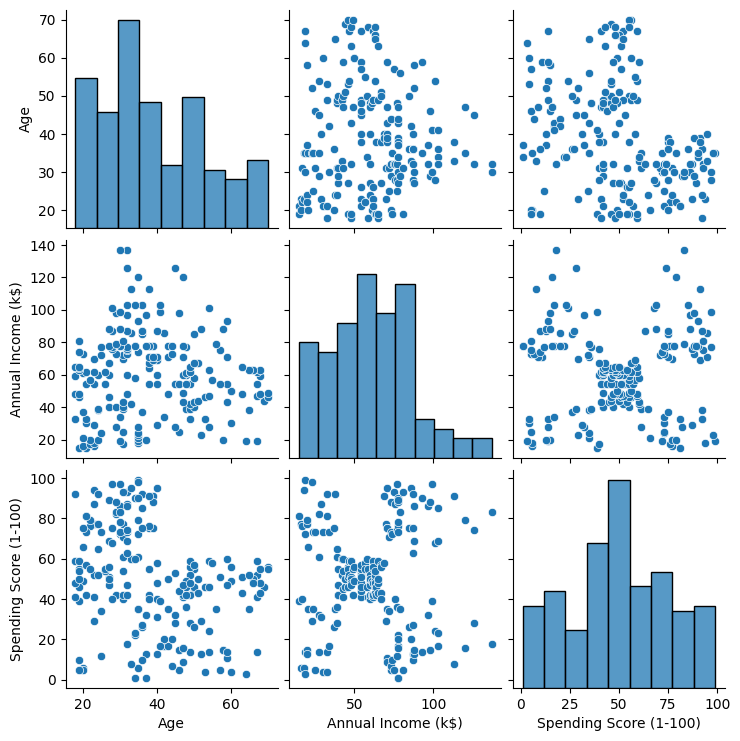

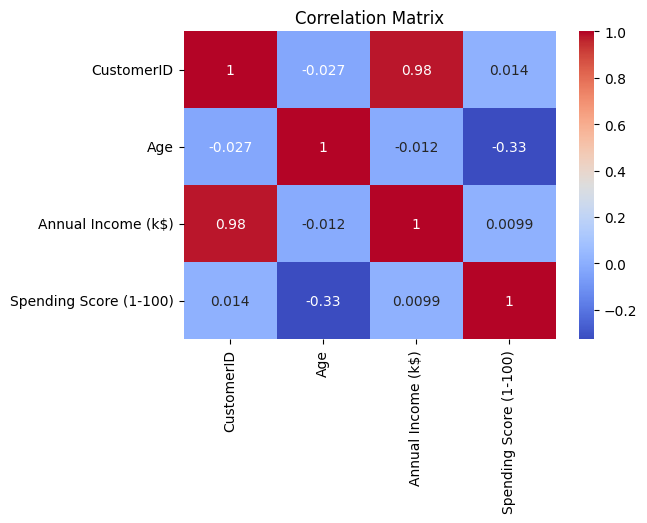

In [47]:
print("\n--- Basic Info ---")
print(df.info())

print("\n--- Summary Statistics ---")
print(df.describe())

print("\n--- Missing Values ---")
print(df.isnull().sum())

# Pairplot or correlation heatmap
sns.pairplot(df[['Age', 'Annual Income (k$)', 'Spending Score (1-100)']])
plt.show()

plt.figure(figsize=(6,4))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

## Part 3. Data Preprocessing

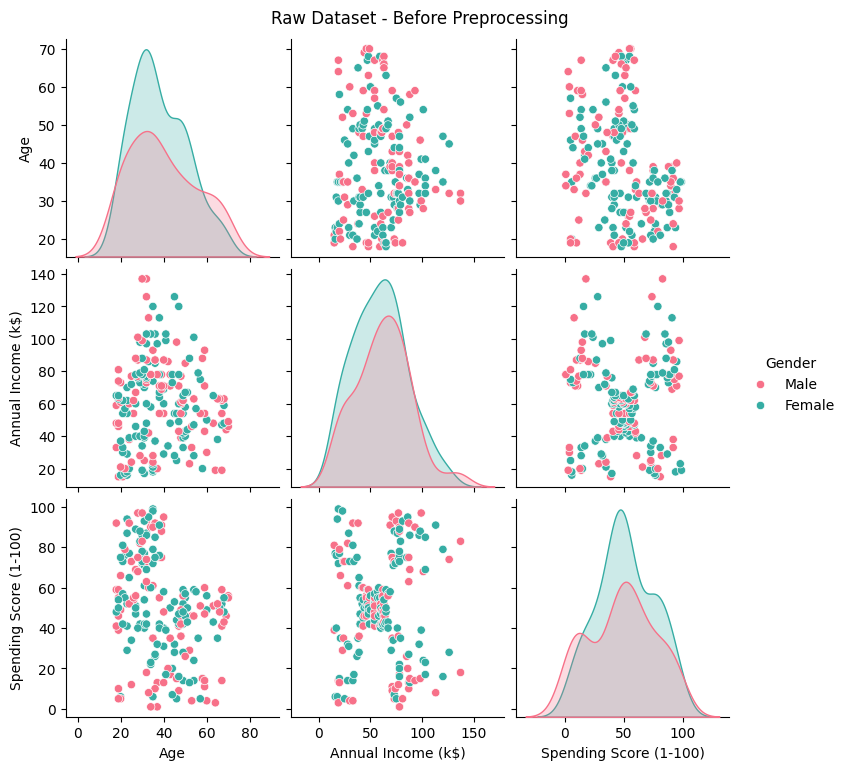

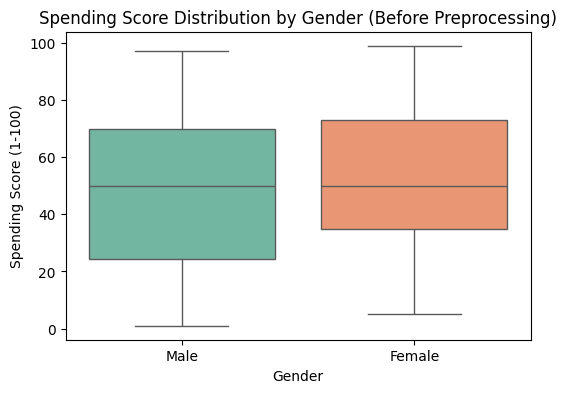

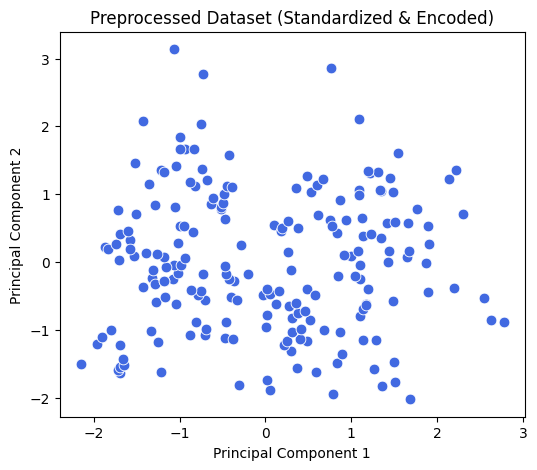

In [48]:
# 3A. Visualize Raw Dataset (Before Preprocessing)

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Use hue='Gender' to apply palette meaningfully
sns.pairplot(
    df,
    vars=['Age', 'Annual Income (k$)', 'Spending Score (1-100)'],
    hue='Gender',
    diag_kind='kde',
    palette='husl'
)
plt.suptitle("Raw Dataset - Before Preprocessing", y=1.02)
plt.show()

# Gender-based Spending visualization
plt.figure(figsize=(6,4))
sns.boxplot(
    data=df,
    x='Gender',
    y='Spending Score (1-100)',
    hue='Gender',
    palette='Set2',
    legend=False
)
plt.title('Spending Score Distribution by Gender (Before Preprocessing)')
plt.show()


# 3B. Visualize After Preprocessing
 
# Encode Gender and scale features for clustering visualization
le = LabelEncoder()
df_enc = df.copy()
df_enc['Gender'] = le.fit_transform(df_enc['Gender'])
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_enc.drop(columns=['CustomerID'], errors='ignore'))

# PCA reduction for 2D visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])

plt.figure(figsize=(6,5))
sns.scatterplot(
    data=pca_df,
    x='PC1',
    y='PC2',
    s=60,
    color='royalblue'
)
plt.title('Preprocessed Dataset (Standardized & Encoded)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

## Part 4. K-Means Clustering

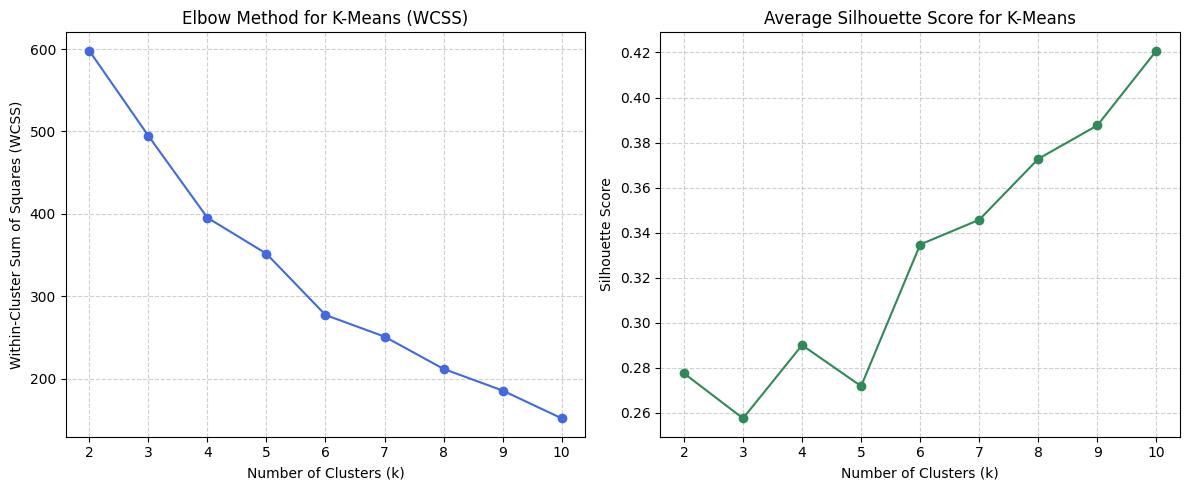

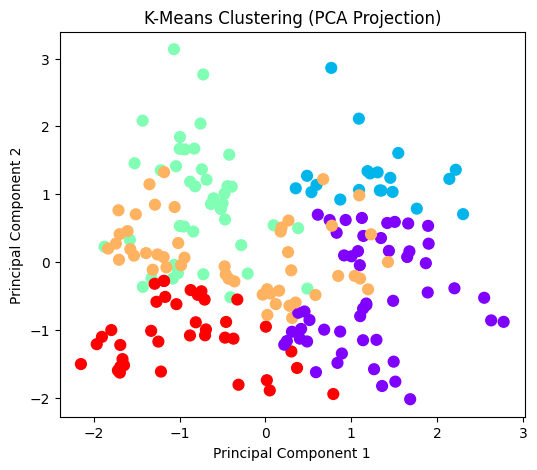

In [49]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import numpy as np

# Elbow method (WCSS) and Silhouette Score side-by-side
wcss = []
silhouette_scores = []
K_range = range(2, 11)

for k in K_range:
    km = KMeans(n_clusters=k, random_state=42)
    labels = km.fit_predict(X_scaled)
    wcss.append(km.inertia_)
    sil_score = silhouette_score(X_scaled, labels)
    silhouette_scores.append(sil_score)

# ---- Plot both side-by-side ----
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Elbow Method (WCSS)
axes[0].plot(K_range, wcss, marker='o', color='royalblue')
axes[0].set_title('Elbow Method for K-Means (WCSS)')
axes[0].set_xlabel('Number of Clusters (k)')
axes[0].set_ylabel('Within-Cluster Sum of Squares (WCSS)')
axes[0].grid(True, linestyle='--', alpha=0.6)

# Silhouette Score
axes[1].plot(K_range, silhouette_scores, marker='o', color='seagreen')
axes[1].set_title('Average Silhouette Score for K-Means')
axes[1].set_xlabel('Number of Clusters (k)')
axes[1].set_ylabel('Silhouette Score')
axes[1].grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

# ---- Apply final K-Means model (example: k=5) ----
kmeans = KMeans(n_clusters=5, random_state=42)
kmeans_labels = kmeans.fit_predict(X_scaled)

# ---- Visualize clusters (PCA projection) ----
plt.figure(figsize=(6,5))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans_labels, cmap='rainbow', s=60)
plt.title('K-Means Clustering (PCA Projection)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

## Part 5. K-Medoids (PAM) Clustering

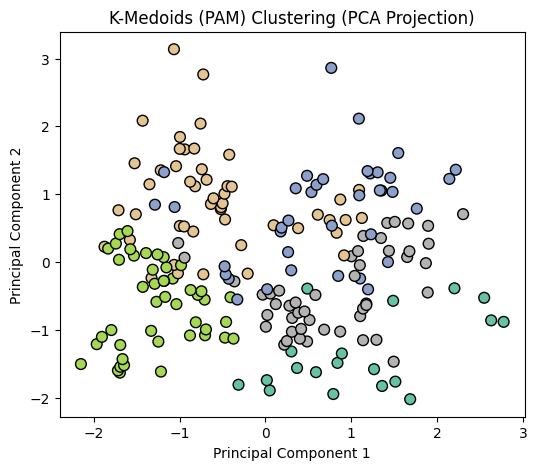

In [50]:
from sklearn_extra.cluster import KMedoids
import matplotlib.pyplot as plt

# Fit model
kmedoids = KMedoids(n_clusters=5, metric='euclidean', random_state=42)
pam_labels = kmedoids.fit_predict(X_scaled)

# Visualize clusters (PCA projection)
plt.figure(figsize=(6,5))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=pam_labels, cmap='Set2', s=60, edgecolor='k')
plt.title('K-Medoids (PAM) Clustering (PCA Projection)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

## Part 6. Agglomerative Hierarchical Clustering

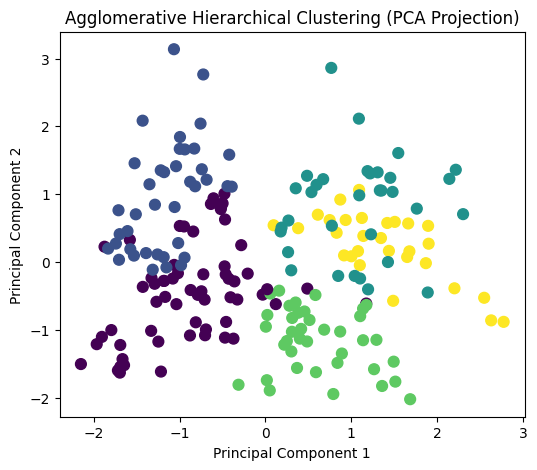

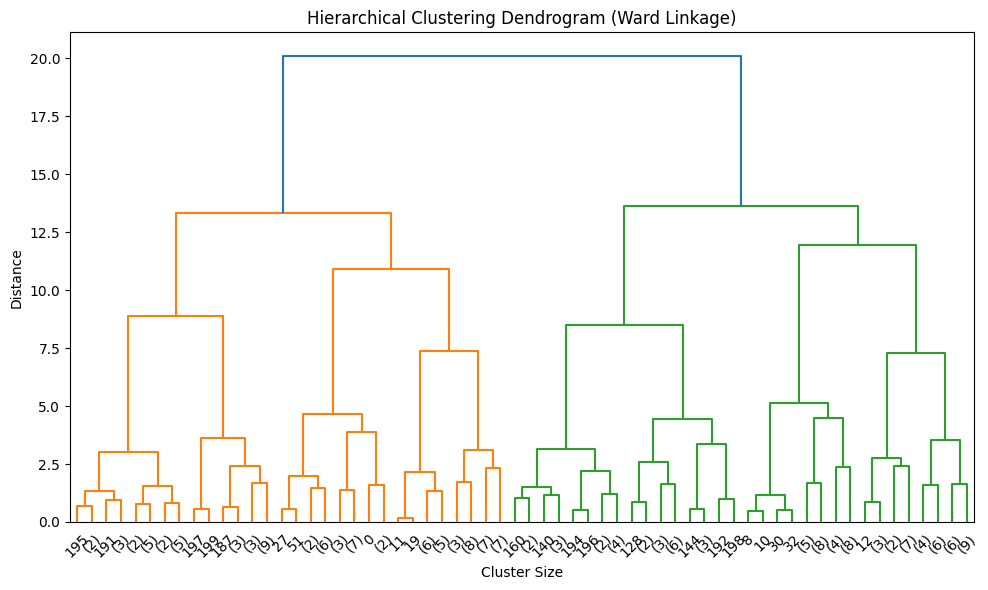

In [51]:
from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage

# --- Existing Code ---
agg = AgglomerativeClustering(n_clusters=5, linkage='ward')
agg_labels = agg.fit_predict(X_scaled)

plt.figure(figsize=(6,5))
plt.scatter(X_pca[:,0], X_pca[:,1], c=agg_labels, cmap='viridis', s=60)
plt.title('Agglomerative Hierarchical Clustering (PCA Projection)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

# --- Hierarchical Clustering Dendrogram (Ward Linkage) ---

# Perform hierarchical clustering on full dataset
# (if necessary, X_scaled[::2])
Z = linkage(X_scaled, method='ward')

plt.figure(figsize=(10, 6))
dendrogram(
    Z,
    truncate_mode='level',  # use 'lastp' or 'level' to display
    p=5,                    # number of cluster levels to show
    leaf_rotation=45.,
    leaf_font_size=10.,
    show_contracted=True,
)
plt.title('Hierarchical Clustering Dendrogram (Ward Linkage)')
plt.xlabel('Cluster Size')
plt.ylabel('Distance')
plt.tight_layout()
plt.show()

## Part 7. DBSCAN Clustering

Estimated number of clusters (excluding noise): 9


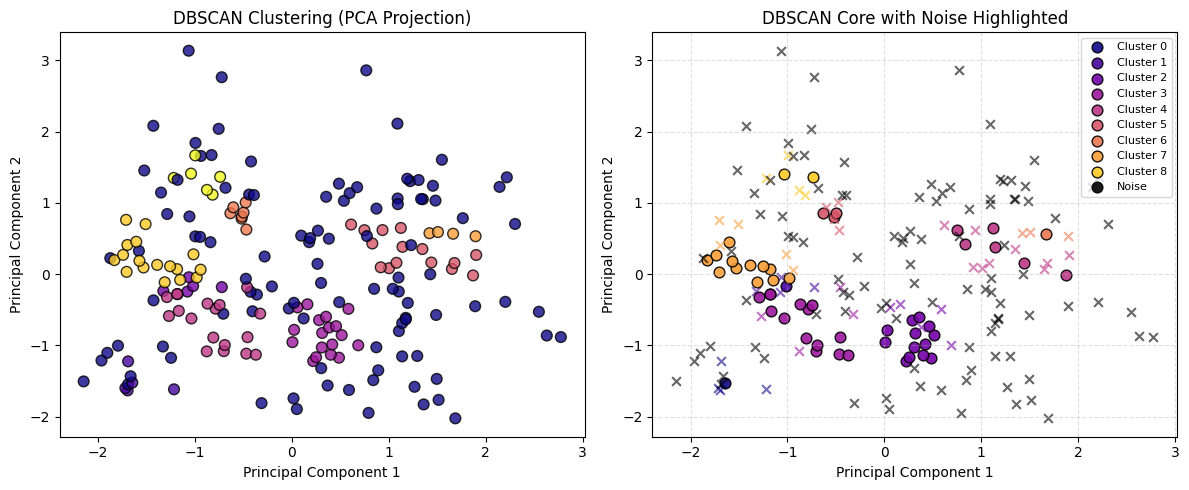

In [52]:
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
from matplotlib import colormaps
import numpy as np

# Fit DBSCAN model
dbscan = DBSCAN(eps=0.5, min_samples=5)
db_labels = dbscan.fit_predict(X_scaled)

# Identify core samples and noise
core_samples_mask = np.zeros_like(db_labels, dtype=bool)
core_samples_mask[dbscan.core_sample_indices_] = True

# Number of clusters (excluding noise if present)
n_clusters_ = len(set(db_labels)) - (1 if -1 in db_labels else 0)
print(f"Estimated number of clusters (excluding noise): {n_clusters_}")

# ---- Create side-by-side plots ----
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
cmap = colormaps["plasma"]

# --- (Left) Standard DBSCAN Clustering ---
scatter1 = axes[0].scatter(
    X_pca[:, 0],
    X_pca[:, 1],
    c=db_labels,
    cmap=cmap,
    s=60,
    edgecolor='k',
    alpha=0.8
)
axes[0].set_title("DBSCAN Clustering (PCA Projection)")
axes[0].set_xlabel("Principal Component 1")
axes[0].set_ylabel("Principal Component 2")

# --- (Right) DBSCAN Core vs Noise Highlighted ---
unique_labels = set(db_labels)
colors = [cmap(each / max(1, len(unique_labels)-1)) for each in range(len(unique_labels))]

for k, col in zip(unique_labels, colors):
    if k == -1:
        # Noise (black or dark gray)
        col = (0, 0, 0, 1)
    class_member_mask = (db_labels == k)
    
    xy_core = X_pca[class_member_mask & core_samples_mask]
    xy_border = X_pca[class_member_mask & ~core_samples_mask]
    
    # Core points
    axes[1].scatter(
        xy_core[:, 0],
        xy_core[:, 1],
        s=60,
        c=[col],
        marker='o',
        edgecolor='k',
        label=f'Cluster {k}' if k != -1 else 'Noise',
        alpha=0.9
    )
    
    # Border or noise points
    axes[1].scatter(
        xy_border[:, 0],
        xy_border[:, 1],
        s=40,
        c=[col],
        marker='x',
        alpha=0.6
    )

axes[1].set_title("DBSCAN Core with Noise Highlighted")
axes[1].set_xlabel("Principal Component 1")
axes[1].set_ylabel("Principal Component 2")
axes[1].legend(loc='best', fontsize=8)
axes[1].grid(True, linestyle='--', alpha=0.4)

plt.tight_layout()
plt.show()

## Part 8. Gaussian Mixture Models (GMM)

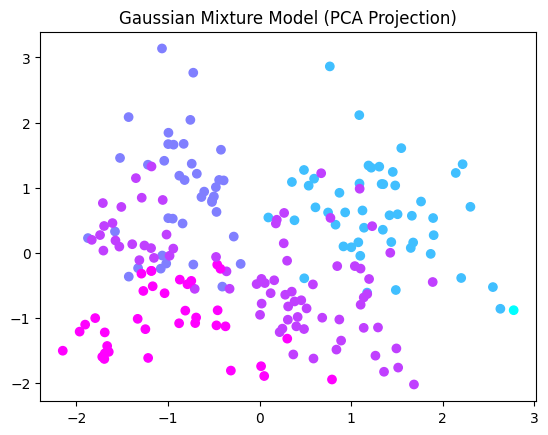

In [53]:
gmm = GaussianMixture(n_components=5, covariance_type='full', random_state=42)
gmm_labels = gmm.fit_predict(X_scaled)

plt.scatter(X_pca[:,0], X_pca[:,1], c=gmm_labels, cmap='cool')
plt.title('Gaussian Mixture Model (PCA Projection)')
plt.show()

## Part 9. Bayesian Gaussian Mixture (Bayesian GMM)

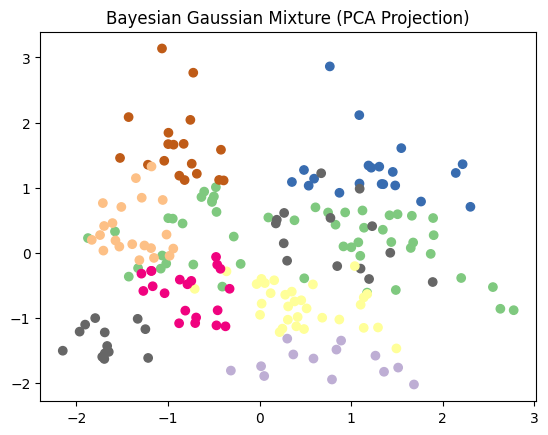

In [54]:
vgmm = BayesianGaussianMixture(n_components=10, covariance_type='full', random_state=42)
vgmm_labels = vgmm.fit_predict(X_scaled)

plt.scatter(X_pca[:,0], X_pca[:,1], c=vgmm_labels, cmap='Accent')
plt.title('Bayesian Gaussian Mixture (PCA Projection)')
plt.show()

## Part 10. Evaluation Metrics

In [55]:
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import pandas as pd

# Function to compute metrics
def compute_metrics(X, labels):
    """Compute Silhouette, Davies-Bouldin, and Calinski-Harabasz scores if valid clusters exist."""
    if len(set(labels)) > 1 and -1 not in set(labels):
        sil = silhouette_score(X, labels)
        db = davies_bouldin_score(X, labels)
        ch = calinski_harabasz_score(X, labels)
        return round(sil, 3), round(db, 3), round(ch, 3)
    else:
        return None, None, None

# Compute metrics for all models
results = {
    'K-Means': compute_metrics(X_scaled, kmeans_labels),
    'K-Medoids (PAM)': compute_metrics(X_scaled, pam_labels),
    'Agglomerative Hierarchical': compute_metrics(X_scaled, agg_labels),
    'DBSCAN': compute_metrics(X_scaled, db_labels),
    'GMM': compute_metrics(X_scaled, gmm_labels),
    'Bayesian GMM': compute_metrics(X_scaled, vgmm_labels)
}

# Convert to DataFrame
metrics_df = pd.DataFrame(results, index=['Silhouette Score', 'Davies-Bouldin Score', 'Calinski-Harabasz Score']).T

# Display neatly
display(metrics_df.style.background_gradient(cmap='Blues', subset=['Silhouette Score'])
                           .format(precision=3)
                           .set_caption("Table 1. Clustering Evaluation Metrics Across Methods"))

,Silhouette Score,Davies-Bouldin Score,Calinski-Harabasz Score
K-Means,0.272,1.181,62.126
K-Medoids (PAM),0.243,1.385,49.939
Agglomerative Hierarchical,0.287,1.220,64.469
DBSCAN,None,None,None
GMM,0.222,1.211,45.817
Bayesian GMM,0.415,0.835,86.123


## Part 11. Cluster Profile Summary

In [56]:
import pandas as pd
results_df = df.copy()

# Attach cluster labels for each technique 
results_df['KMeans_Cluster']        = kmeans_labels
results_df['KMedoids_Cluster']      = pam_labels
results_df['Agglomerative_Cluster'] = agg_labels
results_df['DBSCAN_Cluster']        = db_labels
results_df['GMM_Cluster']           = gmm_labels
results_df['Bayesian_Cluster']      = vgmm_labels   # Dirichlet Process / Bayesian GMM

# function to compute and print the profile summary
def cluster_profile_summary(df, cluster_col):
    """
    the mean profile of each cluster for numeric variables.
    """
    ## print(f"\n--- Cluster Profile Summary ({cluster_col}) ---")
    summary = df.groupby(cluster_col).mean(numeric_only=True)
    ## print(summary)
    return summary

# Generate and store all summaries
summaries = {}
summaries['K-Means']        = cluster_profile_summary(results_df, 'KMeans_Cluster')
summaries['K-Medoids (PAM)'] = cluster_profile_summary(results_df, 'KMedoids_Cluster')
summaries['Agglomerative']  = cluster_profile_summary(results_df, 'Agglomerative_Cluster')
summaries['DBSCAN']         = cluster_profile_summary(results_df, 'DBSCAN_Cluster')
summaries['GMM']            = cluster_profile_summary(results_df, 'GMM_Cluster')
summaries['Bayesian']       = cluster_profile_summary(results_df, 'Bayesian_Cluster') 

# Ensure summaries dictionary exists 
if 'summaries' in locals():
    for method, summary in summaries.items():
        if summary is not None and not summary.empty:
            print(f"\n=== {method} Cluster Profile Summary ===")
            display(
                summary.round(2)
                .style.background_gradient(cmap='Purples', axis=None)
                .set_caption(f"Table — {method} Cluster Profile Summary (Mean of Numeric Variables)")
                .format(precision=2)
            )
        else:
            print(f"\n=== {method} Cluster Profile Summary ===")
            print("No valid clusters found or insufficient data for summary.")
else:
    print("⚠️ No summaries found. Please run the previous cell first.")


=== K-Means Cluster Profile Summary ===


,CustomerID,Age,Annual Income (k$),Spending Score (1-100),KMedoids_Cluster,Agglomerative_Cluster,DBSCAN_Cluster,GMM_Cluster,Bayesian_Cluster
KMeans_Cluster,,,,,,,,,
0,65.33,56.47,46.10,39.31,2.86,3.41,1.61,1.96,1.78
1,159.50,39.50,85.15,14.05,1.35,2.20,-1.00,1.00,5.00
2,100.81,28.69,60.90,70.24,2.86,0.62,1.52,1.93,3.50
3,151.51,37.90,82.12,54.45,2.18,1.43,2.29,3.04,5.02
4,50.53,27.32,38.84,56.21,1.71,0.55,1.00,3.89,5.95



=== K-Medoids (PAM) Cluster Profile Summary ===


,CustomerID,Age,Annual Income (k$),Spending Score (1-100),KMeans_Cluster,Agglomerative_Cluster,DBSCAN_Cluster,GMM_Cluster,Bayesian_Cluster
KMedoids_Cluster,,,,,,,,,
0,22.20,45.40,25.65,18.55,1.30,2.95,-1.00,2.50,1.30
1,164.37,38.03,89.11,23.71,2.13,1.66,-0.79,2.16,6.29
2,79.37,26.65,49.80,68.52,3.59,0.28,2.80,3.57,5.35
3,113.73,32.53,66.98,68.27,1.78,1.24,2.06,1.86,3.33
4,89.06,55.26,56.17,48.32,0.94,2.96,2.04,2.36,2.89



=== Agglomerative Cluster Profile Summary ===


,CustomerID,Age,Annual Income (k$),Spending Score (1-100),KMeans_Cluster,KMedoids_Cluster,DBSCAN_Cluster,GMM_Cluster,Bayesian_Cluster
Agglomerative_Cluster,,,,,,,,,
0,62.41,26.15,43.77,58.97,3.10,2.25,1.11,3.10,4.34
1,162.00,32.69,86.54,82.13,2.54,2.56,3.87,2.54,4.85
2,166.09,41.45,89.09,16.18,1.82,1.27,-1.00,1.91,6.67
3,61.21,49.79,44.11,39.66,1.29,2.63,0.42,3.13,3.32
4,74.76,56.55,50.03,41.34,0.21,2.97,2.55,0.97,0.34



=== DBSCAN Cluster Profile Summary ===


,CustomerID,Age,Annual Income (k$),Spending Score (1-100),KMeans_Cluster,KMedoids_Cluster,Agglomerative_Cluster,GMM_Cluster,Bayesian_Cluster
DBSCAN_Cluster,,,,,,,,,
-1,106.16,39.31,63.58,40.85,1.90,1.77,1.73,2.35,4.62
0,13.20,24.00,20.40,75.00,4.00,2.00,0.00,4.00,8.00
1,21.20,25.40,23.60,74.60,2.00,2.80,0.00,2.00,1.00
2,81.17,49.72,53.39,50.33,1.39,4.00,3.00,3.00,4.00
3,83.39,25.44,53.89,48.28,3.94,1.89,0.00,3.94,6.00
4,77.00,57.40,52.07,48.87,0.00,3.60,4.00,1.00,0.00
5,100.43,22.86,61.00,50.43,2.00,3.00,0.00,2.00,1.00
6,108.25,66.50,62.75,50.50,0.00,4.00,4.00,1.00,0.00
7,156.35,31.47,80.47,81.82,3.00,2.35,1.00,3.00,3.00



=== GMM Cluster Profile Summary ===


,CustomerID,Age,Annual Income (k$),Spending Score (1-100),KMeans_Cluster,KMedoids_Cluster,Agglomerative_Cluster,DBSCAN_Cluster,Bayesian_Cluster
GMM_Cluster,,,,,,,,,
0,9.00,64.00,19.00,3.00,0.00,0.00,4.00,-1.00,0.00
1,106.48,48.90,63.15,30.29,0.54,2.23,3.08,1.15,2.08
2,103.92,28.00,62.21,72.10,2.00,2.92,0.46,1.72,3.77
3,118.80,43.82,68.59,49.41,2.07,2.42,1.97,1.55,4.49
4,52.72,26.03,39.53,56.00,3.94,1.67,0.42,1.03,6.17



=== Bayesian Cluster Profile Summary ===


,CustomerID,Age,Annual Income (k$),Spending Score (1-100),KMeans_Cluster,KMedoids_Cluster,Agglomerative_Cluster,DBSCAN_Cluster,GMM_Cluster
Bayesian_Cluster,,,,,,,,,
0,66.55,55.90,46.45,40.55,0.21,2.76,3.72,2.55,0.97
1,55.48,23.48,40.86,63.05,2.00,2.86,0.00,1.48,2.00
2,23.46,41.54,26.54,20.69,1.85,0.00,3.00,-1.00,3.38
3,163.33,32.19,86.05,81.67,3.00,2.19,1.00,5.48,3.00
4,87.84,51.55,55.74,48.81,1.42,3.84,2.48,0.74,3.00
5,159.50,39.50,85.15,14.05,1.00,1.35,2.20,-1.00,1.00
6,88.45,25.45,55.80,46.90,3.85,1.80,0.00,2.60,3.90
7,160.44,33.28,87.11,82.67,2.00,3.00,1.00,2.00,2.00
8,22.77,25.46,25.69,80.54,4.00,2.00,0.00,-0.62,4.00


## Part 12 — Synthesis, Method Rationale, and Comparative Assessment

### What Was Done and Why

**Data & context.** Analyze the Kaggle *Mall Customer Segmentation* dataset (200 customers; features: gender, age, annual income, spending score) to compare a suite of clustering techniques on the same low‑dimensional business problem. The aim was to understand how choices in modeling affect performance, scalability, robustness to outliers/shape, and interpretability.

**EDA (Part 2).** The raw data was explored to verify schema and missingness, computed descriptive statistics, and visualized pairwise relationships (scatter/pair plots, box plots). This established basic patterns (e.g., high‑spending younger customers) and checked for anomalies.

**Preprocessing (Part 3).** Conversion was done for the categorical `Gender` to numeric, and all numeric features were standardized so that distance‑based methods (K‑Means, K‑Medoids, Hierarchical, DBSCAN) operate on comparable scales. Principal Component Analysis (PCA) to 2D was used only for visualization; models were fit on the full standardized feature space.

**Modeling & evaluation (Parts 4–11).**
- **K‑Means (Part 4):** Baseline centroid method. We used the Elbow (within‑cluster sum of squares) and Silhouette curves to choose *k* and plotted PCA‑projected scatterplots to check cluster separation visually.
- **K‑Medoids / PAM (Part 5):** Like K‑Means, but centers are actual data points (medoids), making the method more robust to outliers. Implemented via `scikit‑learn‑extra` for portability.
- **Agglomerative hierarchical clustering (Part 6):** A bottom‑up tree of merges using Ward linkage to minimize within‑cluster variance. A dendrogram was plotted to visualize the hierarchy and decide on *k*.
- **DBSCAN (Part 7):** Density‑based approach that discovers arbitrary‑shaped clusters and explicit noise points. Visualizing core vs. noise points helped understand density‑based structure and outlier detection.
- **Gaussian mixture models (GMM) (Part 8):** Probabilistic mixture model with soft assignments; each component has its own covariance. Model selection via AIC and BIC helped determine the number of components.
- **Bayesian GMM (Part 9):** Introduces a Dirichlet prior over mixture weights so that unnecessary components shrink away, yielding an inferred number of clusters and additional regularization.
- **Evaluation metrics (Part 10):** For each method, the Silhouette, Davies–Bouldin, and Calinski–Harabasz scores were computed and summarized in a table. These internal metrics quantify cohesion and separation, complementing visual assessments.
- **Cluster profiles (Part 11):** The mean of each numeric variable was profiled within each cluster for every method, presenting six tables (one per algorithm). These profiles connect algorithmic output back to interpretable business descriptors (e.g., income and spending patterns by cluster).

### Techniques: main ideas, strengths, limits, and uses

**K‑Means.**  
*Idea:* Partition into *k* spherical clusters by minimizing within‑cluster variance around centroids.  
*Advantages:* Fast, scalable; works well when clusters are compact and similar in size.  
*Disadvantages:* Sensitive to initialization and outliers; assumes roughly spherical clusters; must choose *k*.  
*Applications:* Quick segmentation baselines, market cohort prototypes.

**K‑Medoids (PAM).**  
*Idea:* Use actual observations (medoids) as cluster centers, minimizing average dissimilarity.  
*Advantages:* More robust to outliers; can use non‑Euclidean distance metrics.  
*Disadvantages:* More computationally intensive than K‑Means on larger datasets.  
*Applications:* Retail/CRM cohorts with outliers or mixed data types.

**Agglomerative hierarchical (Ward).**  
*Idea:* Start with individual points and iteratively merge clusters; Ward linkage minimizes the increase in within‑cluster variance.  
*Advantages:* Produces a dendrogram that reveals multiscale structure; no need to pre‑specify *k*; good interpretability.  
*Disadvantages:* Higher time and memory cost (O(n²)); less scalable to very large datasets.  
*Applications:* Exploratory persona discovery, taxonomy building, understanding cluster hierarchy.

**DBSCAN.**  
*Idea:* Density‑based algorithm where points with enough neighbors within a radius *eps* are core points; others are border or noise.  
*Advantages:* Identifies arbitrarily shaped clusters and explicit noise without specifying *k*; robust to outliers.  
*Disadvantages:* Sensitive to `eps` and `min_samples`; struggles with varying densities.  
*Applications:* Anomaly detection, spatial or log data with irregular boundaries.

**Gaussian mixture models (GMM).**  
*Idea:* Fit a mixture of Gaussian distributions with soft (probabilistic) assignments; each component has its own mean and covariance.  
*Advantages:* Flexibility to model elliptical clusters; principled model selection via information criteria (AIC/BIC).  
*Disadvantages:* Assumes Gaussianity; sensitive to initialization; may overfit.  
*Applications:* Soft segmentation, marketing personas with probabilistic membership, anomaly scoring.

**Bayesian GMM.**  
*Idea:* Place a prior on mixture weights and covariance parameters (e.g., Dirichlet process); unused components shrink, effectively learning the number of clusters.  
*Advantages:* Automatically infers cluster count; regularizes complex models; yields uncertainty estimates.  
*Disadvantages:* More computationally demanding; hyperparameters influence results; can converge slowly.  
*Applications:* Cohort discovery when *k* is unknown; scenarios requiring parsimonious models and uncertainty quantification.

### Comparative analysis on this dataset

**Performance (speed):** K‑Means is fastest; PAM is slower; hierarchical is moderate on 200 observations; DBSCAN is relatively fast; GMM and Bayesian GMM incur extra time for EM/variational inference.

**Scalability:** K‑Means and GMM scale well to large `n`; hierarchical and PAM struggle as `n` grows; DBSCAN scales moderately but is sensitive to the curse of dimensionality.

**Robustness:** PAM and DBSCAN handle outliers better than K‑Means or GMM. DBSCAN also discovers non‑spherical patterns and explicit noise. GMM tolerates ellipsoidal clusters via covariance; Bayesian GMM adds regularization to guard against overfitting.

**Interpretability:**  
- **High:** Hierarchical (dendrogram), K‑Means (simple centroids), and PAM (representative medoids).  
- **Moderate:** DBSCAN (core/noise concept is intuitive but parameter‑dependent).  
- **Moderate–Low:** GMM/Bayesian GMM (probabilistic assignments and model complexity are harder to explain to non‑technical audiences).

**Bottom line for mall customers:** In this small, low‑dimensional dataset, K‑Means or GMM produce clear, stable segments for reporting. PAM is a strong alternative when outliers matter. DBSCAN offers outlier and noise discovery, but parameter tuning is needed. Hierarchical clustering is excellent for communicating how clusters form and for exploring different values of *k*. Bayesian GMM is valuable when you need a principled approach to model complexity and cluster uncertainty.

> **Note:** Use internal metrics (Part 10) together with cluster profiles (Part 11) and business understanding to choose the most appropriate segmentation method.

In [57]:
# Summary Table with Automatic Best-k shown

import pandas as pd
import numpy as np

# --- retrieve best k from Silhouette Score list ---
try:
    best_k = K_range[np.argmax(silhouette_scores)]
except Exception:
    best_k = 5   # default fallback
print(f"Detected optimal k (from silhouette): k = {best_k}")


# Table  — Performance, Scalability, Robustness, Interpretability
table_b = pd.DataFrame([
    {"Algorithm": "K-Means",
     "Performance (Speed)": "High",
     "Scalability": "High",
     "Robustness": "Low–Medium",
     "Interpretability": "High (centroids simple)"},
    {"Algorithm": "K-Medoids (PAM)",
     "Performance (Speed)": "Medium",
     "Scalability": "Medium–Low",
     "Robustness": "Medium–High (handles outliers)",
     "Interpretability": "High (actual medoid exemplars)"},
    {"Algorithm": "Agglomerative Hierarchical (Ward)",
     "Performance (Speed)": "Medium",
     "Scalability": "Medium–Low",
     "Robustness": "Medium",
     "Interpretability": "Very High (dendrogram visual)"},
    {"Algorithm": "DBSCAN",
     "Performance (Speed)": "High",
     "Scalability": "Medium",
     "Robustness": "High (outliers + shape-invariant)",
     "Interpretability": "Medium (core/noise distinction)"},
    {"Algorithm": "GMM",
     "Performance (Speed)": "Medium",
     "Scalability": "High",
     "Robustness": "Medium (via covariance)",
     "Interpretability": "Medium (probabilistic)"},
    {"Algorithm": "Bayesian GMM",
     "Performance (Speed)": "Medium–Low",
     "Scalability": "Medium–High",
     "Robustness": "Medium (regularized)",
     "Interpretability": "Medium (model complexity control)"}
])

display(table_b.style.set_caption(
    "Table B — Comparative Evaluation (Performance, Scalability, Robustness, Interpretability)"
))

Detected optimal k (from silhouette): k = 10


,Algorithm,Performance (Speed),Scalability,Robustness,Interpretability
0,K-Means,High,High,Low–Medium,High (centroids simple)
1,K-Medoids (PAM),Medium,Medium–Low,Medium–High (handles outliers),High (actual medoid exemplars)
2,Agglomerative Hierarchical (Ward),Medium,Medium–Low,Medium,Very High (dendrogram visual)
3,DBSCAN,High,Medium,High (outliers + shape-invariant),Medium (core/noise distinction)
4,GMM,Medium,High,Medium (via covariance),Medium (probabilistic)
5,Bayesian GMM,Medium–Low,Medium–High,Medium (regularized),Medium (model complexity control)
